# Friends_dataset_speaker_recognition-LSTM

In [21]:
!pip3 install keras

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)
import pandas as pd
pd.set_option('display.max_colwidth', -1)

1.14.0


In [14]:
df=pd.read_csv("../data/friends_dataset.csv")
df.head()

,Unnamed: 0,Location,Scene,Season,Speaker,Text
0,0,Coffee place,"Joey is there, Chandler is entering",9,Ross,"Ooh, somebody's getting a little fussy."
1,1,Rift’s Restaurant,"as seen in Mad About You, Joey and Chandler are there,",1,Chandler,"This is unbelievable. It’s been like a half an hour. If this was a cartoon, you’d be looking like a ham right about now."
2,2,Monica and Chandler's,"the scene is continued from earlier,",8,Rachel,"Okay, get ready to see some beggin’!"
3,3,Chandler and Joey's,"Chandler is laying on the counter and Rachel and Monica are comforting him again,",3,Rachel,"Yes, and grumpy."
4,4,Monica and Rachel's,"Chandler, Rachel, and Joey are eating, and Phoebe is preparing Ben's milk,",2,Phoebe,"Ben, dinner!"


In [15]:
from io import StringIO
col = ['Speaker', 'Text']
df = df[col]
df = df[pd.notnull(df['Text'])]
df.columns = ['Speaker', 'Text']
df['category_id'] = df['Speaker'].factorize()[0]
category_id_df = df[['Speaker', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Speaker']].values)
df.head(20)


,Speaker,Text,category_id
0,Ross,"Ooh, somebody's getting a little fussy.",0
1,Chandler,"This is unbelievable. It’s been like a half an hour. If this was a cartoon, you’d be looking like a ham right about now.",1
2,Rachel,"Okay, get ready to see some beggin’!",2
3,Rachel,"Yes, and grumpy.",2
4,Phoebe,"Ben, dinner!",3
6,Joey,Don’t you see what this means?! I can forget about that stupid movie. I'm gonna be a millionaire!,4
7,Joey,Dude! He's right there!,4
8,Ross,"Dad, what are you doing?",0
9,Monica,I'm sorry too.,5
10,Ross,Hey listen can you do me a big favor? The dean’s office just called and said there was an urgent meeting. Can you watch Ben for like an hour?,0


In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


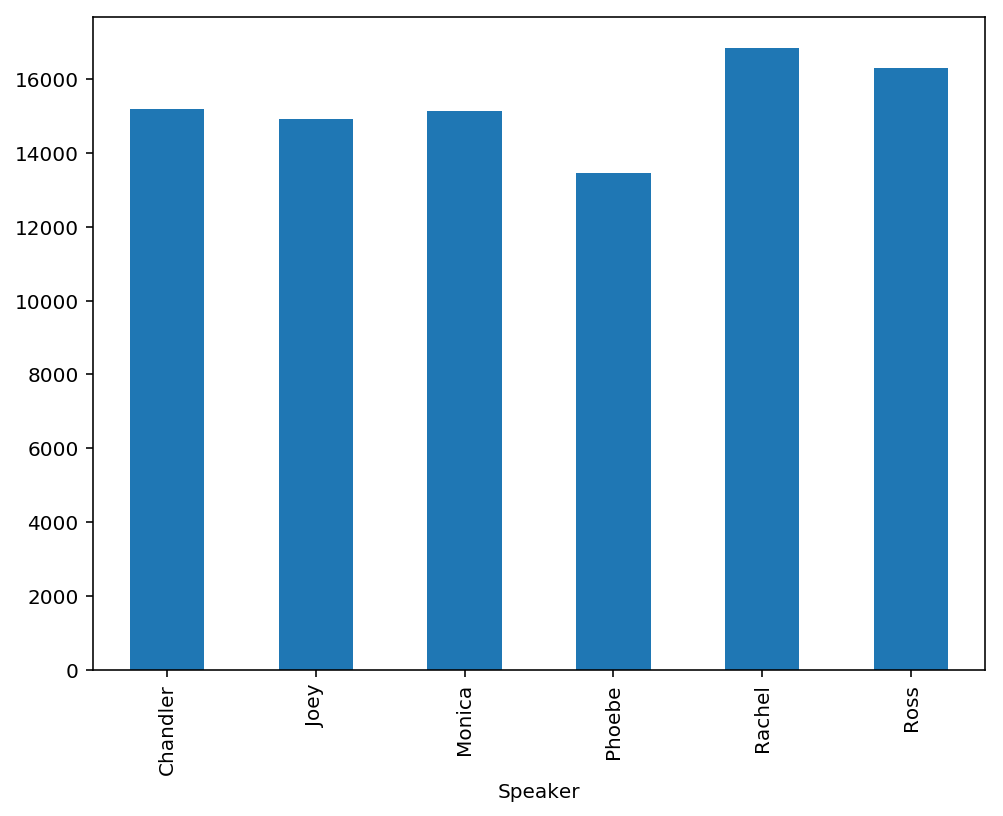

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Speaker').Text.count().plot.bar(ylim=0)
plt.show()

In [18]:
def print_plot(index):
    example = df[df.index == index][['Text']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Text:', example[0])
print_plot(10)

Hey listen can you do me a big favor? The dean’s office just called and said there was an urgent meeting. Can you watch Ben for like an hour?
Text: Hey listen can you do me a big favor? The dean’s office just called and said there was an urgent meeting. Can you watch Ben for like an hour?


In [19]:
import re
from nltk.corpus import stopwords


df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Text'] = df['Text'].apply(clean_text)
df['Text'] = df['Text'].str.replace('\d+', '')
df.head()

,Speaker,Text,category_id
0,Ross,ooh somebodys getting little fussy,0
1,Chandler,unbelievable like half hour cartoon youd looking like ham right,1
2,Rachel,okay get ready see beggin,2
3,Rachel,yes grumpy,2
4,Phoebe,ben dinner,3


In [20]:
print_plot(10)

oh look thats gonna leave stain
Text: oh look thats gonna leave stain


In [24]:

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 128
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14184 unique tokens.


In [25]:
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (91824, 200)


In [30]:
Y = pd.get_dummies(df['category_id']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (91824, 6)


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(61522, 200) (61522, 6)
(30302, 200) (30302, 6)


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='sigmoid'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 24)                614424    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 7,014,574
Trainable params: 7,014,574
Non-trainable params: 0
_________________________________________________________________


In [33]:
num_epochs = 10
model.fit(X_train, Y_train, epochs=num_epochs, validation_data=(X_test, Y_test))

Train on 61522 samples, validate on 30302 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
61522/61522 [==============================] - 131s 2ms/sample - loss: 1.7090 - acc: 0.2749 - val_loss: 1.5990 - val_acc: 0.3625
Epoch 2/10
61522/61522 [==============================] - 130s 2ms/sample - loss: 1.3337 - acc: 0.4972 - val_loss: 1.4005 - val_acc: 0.4588
Epoch 3/10
61522/61522 [==============================] - 125s 2ms/sample - loss: 1.0406 - acc: 0.6040 - val_loss: 1.3235 - val_acc: 0.5032
Epoch 4/10
61522/61522 [==============================] - 122s 2ms/sample - loss: 0.9056 - acc: 0.6495 - val_loss: 1.3051 - val_acc: 0.5239
Epoch 5/10
61522/61522 [==============================] - 124s 2ms/sample - loss: 0.8368 - acc: 0.6698 - val_loss: 1.3035 - val_acc: 0.5343
Epoch 6/10
61522/61522 [==============================] - 121s 2ms/sample - loss: 0.7960 - acc: 0.6843 - val_loss: 1.2977 - val_acc: 0.5435
Epoch 7/10
61522

In [34]:
y = tokenizer.texts_to_sequences("And I will be using his dead body as a shield")
y = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y_pred=model.predict(y)

In [35]:
y_pred

array([[3.6678475e-01, 3.1119585e-04, 3.9964914e-04, 2.2053719e-04,
        2.6533008e-04, 3.0970573e-04],
       [2.8809905e-04, 6.0473460e-01, 1.4391541e-04, 5.3882599e-05,
        9.9837780e-05, 3.0407310e-04],
       [6.7359209e-04, 4.9358606e-04, 4.9468163e-01, 2.1243095e-04,
        2.5275350e-04, 3.1402707e-04],
       ...,
       [3.5709143e-04, 1.3643205e-03, 5.3107738e-04, 1.0201037e-03,
        2.4467707e-05, 1.3073617e-01],
       [4.1282177e-04, 4.4876337e-04, 3.5196543e-04, 2.7608871e-04,
        9.7662210e-05, 3.4245849e-04],
       [2.9093027e-04, 3.6215782e-04, 2.1848083e-04, 1.3175607e-04,
        2.9844046e-04, 3.5521388e-04]], dtype=float32)

In [36]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(50000, 128)


In [37]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(X_train[1]))
print(X_train[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? yeah im gonna pass cause kinda iffy puppies
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

In [38]:
# import io

# out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# for word_num in range(1, len(reverse_word_index)):
#   word = reverse_word_index[word_num]
#   embeddings = weights[word_num]
#   out_m.write(word + "\n")
#   out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [27]:
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(tf.keras.layers.SpatialDropout1D(0.2))
model1.add(tf.keras.layers.LSTM(24, dropout=0.2, recurrent_dropout=0.2))
model1.add(tf.keras.layers.Dense(6, activation='sigmoid'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model1.fit(X_train, Y_train, epochs=epochs,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 55369 samples, validate on 6153 samples
Epoch 1/10
55369/55369 [==============================] - 348s 6ms/sample - loss: 1.7196 - acc: 0.2656 - val_loss: 1.6491 - val_acc: 0.3387
Epoch 2/10
55369/55369 [==============================] - 322s 6ms/sample - loss: 1.5052 - acc: 0.4030 - val_loss: 1.5534 - val_acc: 0.3762
Epoch 3/10
55369/55369 [==============================] - 323s 6ms/sample - loss: 1.3385 - acc: 0.4671 - val_loss: 1.5193 - val_acc: 0.4070
Epoch 4/10
55369/55369 [==============================] - 323s 6ms/sample - loss: 1.2355 - acc: 0.5032 - val_loss: 1.5014 - val_acc: 0.4161
Epoch 5/10
55369/55369 [==============================] - 341s 6ms/sample - loss: 1.1694 - acc: 0.5234 - val_loss: 1.4986 - val_acc: 0.4294
Epoch 6/10
55369/55369 [==============================] - 368s 7ms/sample - loss: 1.1155 - acc: 0.5407 - val_loss: 1.5116 - val_acc: 0.4330
Epoch 7/10
55369/55369 [==============================] - 336s 6ms/sample - loss: 1.0740 - acc: 0.5554 - val_lo

In [ ]:
#tokenizer = info.features['text'].encoder

In [44]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='sigmoid'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10

history = model2.fit(X_train, Y_train, epochs=epochs,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 55369 samples, validate on 6153 samples
Epoch 1/10
55369/55369 [==============================] - 7890s 143ms/sample - loss: 1.7681 - acc: 0.2156 - val_loss: 1.7261 - val_acc: 0.2693
Epoch 2/10
55369/55369 [==============================] - 705s 13ms/sample - loss: 1.6149 - acc: 0.3454 - val_loss: 1.6290 - val_acc: 0.3431
Epoch 3/10
55369/55369 [==============================] - 706s 13ms/sample - loss: 1.4182 - acc: 0.4486 - val_loss: 1.5483 - val_acc: 0.4022
Epoch 4/10
55369/55369 [==============================] - 732s 13ms/sample - loss: 1.2478 - acc: 0.5196 - val_loss: 1.4991 - val_acc: 0.4240
Epoch 5/10
55369/55369 [==============================] - 738s 13ms/sample - loss: 1.1320 - acc: 0.5634 - val_loss: 1.4902 - val_acc: 0.4432
Epoch 6/10
55369/55369 [==============================] - 761s 14ms/sample - loss: 1.0527 - acc: 0.5891 - val_loss: 1.4896 - val_acc: 0.4598
Epoch 7/10
55369/55369 [==============================] - 715s 13ms/sample - loss: 0.9932 - acc: 0.6109

In [ ]:
from sklearn.externals import joblib
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, filename)

# some time later...

# # load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)


In [ ]:
import pickle
# save the model to disk
filename = 'predict_Speaker_from_Dialogue_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [41]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32747/32747 [==============================] - 9s 263us/sample - loss: 1.4996 - accuracy: 0.6097
Test set
  Loss: 1.500
  Accuracy: 0.610


In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


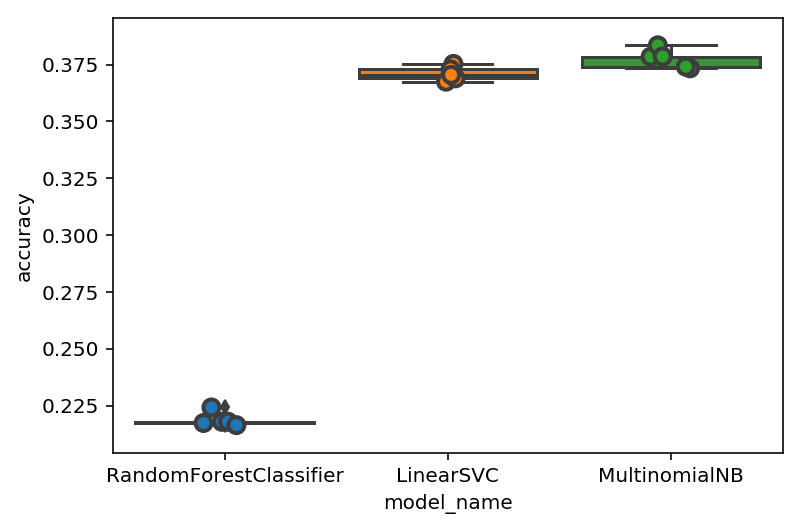

In [250]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(multi_class="crammer_singer"),
    MultinomialNB()
    #LogisticRegression(multi_class="multinomial")
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [239]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(0,1), stop_words='english')
features = tfidf.fit_transform(df.dialogue).toarray()
labels = df.Character
features.shape

(99233, 6438)

In [39]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Score, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Score))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Chandler':
  . Most correlated unigrams:
. heyhey
. zoo
  . Most correlated bigrams:
. hey whats
. hey yknow
# 'Joey':
  . Most correlated unigrams:
. heyhey
. zoo
  . Most correlated bigrams:
. hey whats
. hey yknow
# 'Monica':
  . Most correlated unigrams:
. heyhey
. zoo
  . Most correlated bigrams:
. hey whats
. hey yknow
# 'Phoebe':
  . Most correlated unigrams:
. heyhey
. zoo
  . Most correlated bigrams:
. hey whats
. hey yknow
# 'Rachel':
  . Most correlated unigrams:
. heyhey
. zoo
  . Most correlated bigrams:
. hey whats
. hey yknow
# 'Ross':
  . Most correlated unigrams:
. heyhey
. zoo
  . Most correlated bigrams:
. hey whats
. hey yknow


In [246]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['dialogue'], df['Character'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [43]:
# model = LinearSVC()
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
# model.fit(X_train, y_train)
# X_test = X_test.reshape(X_test.shape[1:])
# X_test=X_test.transpose()
y_pred = model.predict(X_test)
y_pred.shape



(32747, 6)

In [44]:
y_pred

array([[7.1770960e-01, 4.6521425e-05, 4.0143728e-05, 2.1061003e-03,
        4.1037798e-05, 4.2095780e-04],
       [2.8312206e-06, 3.3974648e-06, 5.7131052e-05, 5.5988896e-01,
        2.6822090e-07, 0.0000000e+00],
       [7.0959330e-05, 4.8140511e-01, 1.3589859e-05, 1.4901161e-07,
        1.4245510e-05, 1.9699335e-05],
       ...,
       [2.5752187e-04, 7.5161457e-04, 3.1387806e-04, 1.0300577e-03,
        2.5299191e-04, 2.2835732e-03],
       [8.0466270e-06, 5.9031498e-01, 2.1755695e-06, 0.0000000e+00,
        2.2649765e-06, 6.0200691e-06],
       [9.0301037e-05, 5.6526065e-04, 2.9435754e-04, 1.9617379e-03,
        3.8734099e-05, 8.9522533e-04]], dtype=float32)

In [45]:
import numpy as np
y_pred=np.argmax(y_pred, axis=1)

In [46]:
Y_test=np.argmax(Y_test, axis=1)
Y_test

array([0, 3, 1, ..., 3, 1, 5])

In [47]:
y_pred


array([0, 3, 1, ..., 5, 1, 3])

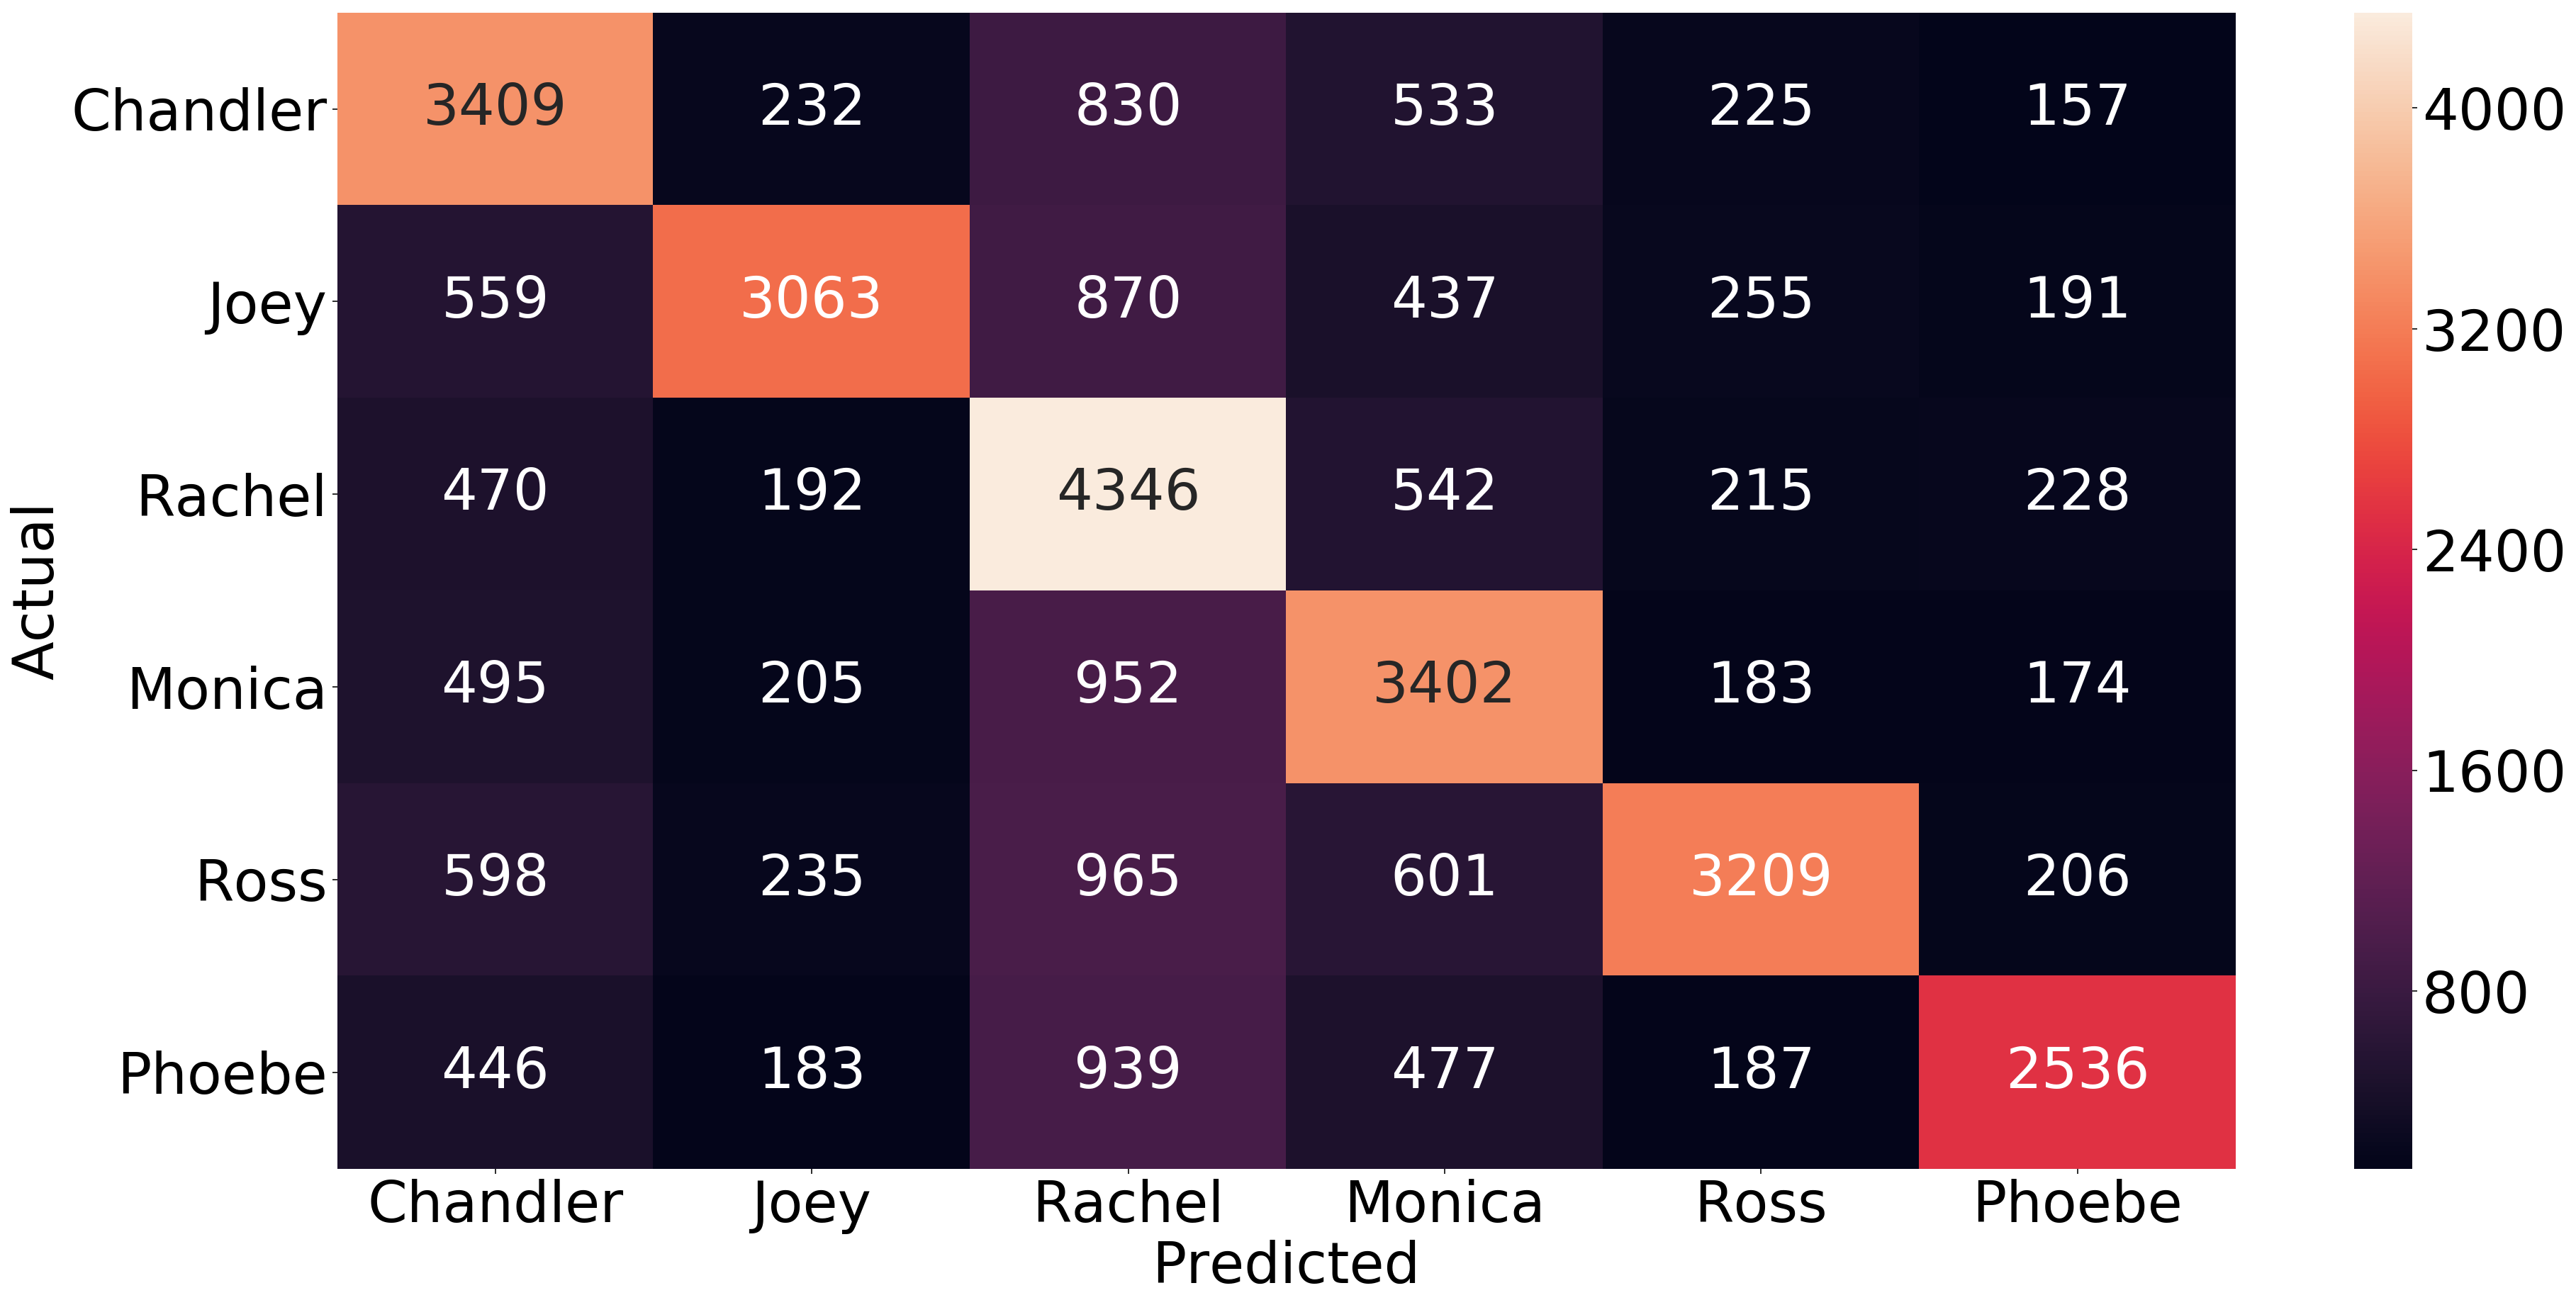

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(Y_test, y_pred)
fig, ax = plt.subplots(figsize=(30,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Character.values, yticklabels=category_id_df.Character.values)
plt.rcParams.update({'font.size': 50})

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
